![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()


,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         10495 non-null  int64
 1   Mileage      10495 non-null  int64
 2   M_Camry      10495 non-null  uint8
 3   M_Camry4dr   10495 non-null  uint8
 4   M_CamryBase  10495 non-null  uint8
 5   M_CamryL     10495 non-null  uint8
 6   M_CamryLE    10495 non-null  uint8
 7   M_CamrySE    10495 non-null  uint8
 8   M_CamryXLE   10495 non-null  uint8
 9   HighPrice    10495 non-null  int64
dtypes: int64(3), uint8(7)
memory usage: 657.8 KB


In [4]:
uint8_columns = ['M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
data[uint8_columns] = data[uint8_columns].astype(int)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         10495 non-null  int64
 1   Mileage      10495 non-null  int64
 2   M_Camry      10495 non-null  int64
 3   M_Camry4dr   10495 non-null  int64
 4   M_CamryBase  10495 non-null  int64
 5   M_CamryL     10495 non-null  int64
 6   M_CamryLE    10495 non-null  int64
 7   M_CamrySE    10495 non-null  int64
 8   M_CamryXLE   10495 non-null  int64
 9   HighPrice    10495 non-null  int64
dtypes: int64(10)
memory usage: 1.1 MB


In [6]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
x = data.drop(['HighPrice'], axis=1)

In [7]:
# Separación de datos en set de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [29]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):


    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = predict( X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = predict(X_r, tree['sr'], proba)

    return predicted 

In [31]:
tree = tree_grow(X=x_train, y=y_train, level=0, min_gain=0.001, max_depth=20, num_pct=10)
# Predecimos los valores y para los datos usados en el entrenamiento
y_pred = predict(x_test, tree)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8608545034642032


#### Calibración Max_depth

In [41]:
max_depth = range(1, 50, 10)
accuracy_scores_tree = []
for feature in max_depth:
    tree = tree_grow(X=x_train, y=y_train, level=0, min_gain=0.001, max_depth=feature, num_pct=10)
    y_pred = predict(x_test, tree)
    accuracy_scores_tree.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Accuracy')

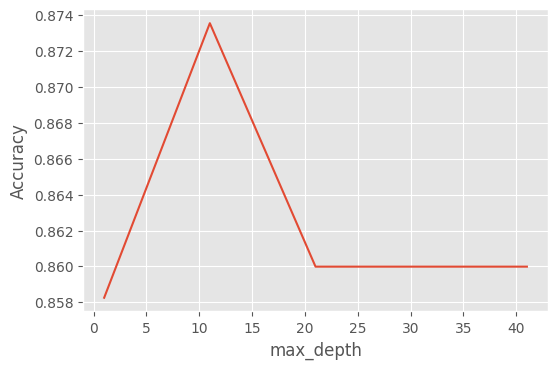

In [42]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(max_depth, accuracy_scores_tree)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [53]:
accu_TreeManual = np.max(accuracy_scores_tree)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [35]:
def baggingManual(xtrain:pd.DataFrame, ytrain:pd.DataFrame=y_train, xtest:pd.DataFrame=x_test ,num_arboles:int=10):
    #semilla
    np.random.seed(123)
    # Creación de 10 muestras de bootstrap 
    n_samples = xtrain.shape[0]
    samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, num_arboles + 1 )]
    
    # DataFrame para guardar las predicciones de cada árbol
    y_pred = pd.DataFrame(index=xtest.index, columns=[list(range(num_arboles))])

    # Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
    for i, sample in enumerate(samples):
        xtrain.reset_index(drop=True, inplace=True)
        ytrain.reset_index(drop=True, inplace=True)
        x_train = xtrain.iloc[sample, :]
        y_train = ytrain.iloc[sample]
        tree = tree_grow(X=x_train, y=y_train, level=0, min_gain=0.001, max_depth=feature, num_pct=10)
        y_pred.iloc[:,i] = predict(xtest, tree)

    return y_pred   


In [36]:
accuracy_scores=[]
y_pred = baggingManual(x_train,y_train,x_test,num_arboles=15)
for pred in range(15):
    accuracy_scores.append(accuracy_score(y_test,y_pred.iloc[:,pred]))

Text(0, 0.5, 'Accuracy')

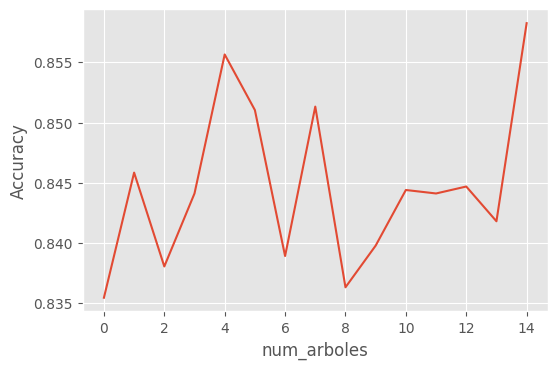

In [37]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(range(0,15), accuracy_scores)
plt.xlabel('num_arboles')
plt.ylabel('Accuracy')

In [56]:
accu_bagginManual = np.max(accuracy_scores)
print("Accuracy Bagging Manual:",accu_bagginManual)

Accuracy Bagging Manual: 0.858256351039261


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [10]:
# Celda 3
# https://stackoverflow.com/questions/42072721/valueerror-max-features-must-be-in-0-n-features-in-scikit-when-using-rand
max_features = np.log(x_train.shape[1])/x_train.shape[1]
clf_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='gini'), n_estimators= 10, max_features=max_features, random_state=12261922)
clf_bagging.fit(x_train, y_train)
y_bagging = clf_bagging.predict(x_test)
accuracy_bagging = accuracy_score(y_test, y_bagging)

In [59]:
print("Accuracy Bagging Con Libreria:",accuracy_bagging)

Accuracy Bagging Con Libreria: 0.8576789838337182


Teniendo en cuenta el desempeño general del Árbol de Decisión Manual, Con un “Accuracy” pobre de tan solo 58%, el desempeño del Bagging usando librería de Sklearn presenta un salto cualitativo de desempeño mayoe que 85% que es una métrica bastante aceptable, aunque mejorable sin duda a través de modelos más robustos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [12]:
# Celda 4
clf_forest = RandomForestClassifier(random_state=12261922)
clf_forest.fit(x_train, y_train)
y_forest = clf_forest.predict(x_test)
accuracy_forest = accuracy_score(y_test, y_forest)

In [60]:
print("Accuracy Random Forest Con Librería:",accuracy_forest)

Accuracy Random Forect Con Libreri: 0.8435334872979214


En el caso de Random Forest vs.Bagging.  el ajuste adicional del primero a partir del remuestreo aleatorio no entrega un desempeño cuantitativamente superior. Ni siquiera igual. Pese a ello con algo de calibración podría mejorar su resultado.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [14]:
# Celda 5
# pipe = Pipeline([('model', RandomForestClassifier())])
# param_grid = {'model__max_depth': [*range(1, 16, 1)],
#               'model__max_features': [*range(1, x_train.shape[1]+1, 1)],
#               'model__n_estimators': [*range(100, 1001, 60)]}
# search_forest = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=10)
# _ = search_forest.fit(x_train, y_train)
# joblib.dump(search_forest, 'search_forest.joblib')

In [15]:
search_forest = joblib.load('search_forest.joblib') 

In [16]:
values = (search_forest.best_params_['model__max_depth'], search_forest.best_params_['model__max_features'], search_forest.best_params_['model__n_estimators'], search_forest.best_score_)
print('Params\n max_depth %d\n max_features %d\n n_estimators %d\n\ntest accuracy %.4f' % values)

Params
 max_depth 7
 max_features 2
 n_estimators 220

test accuracy 0.8852


In [17]:
params = pd.DataFrame(search_forest.cv_results_['params'])
params['accuracy'] = search_forest.cv_results_['mean_test_score']
params.head()

,model__max_depth,model__max_features,model__n_estimators,accuracy
0,1,1,100,0.810273
1,1,1,160,0.819803
2,1,1,220,0.818096
3,1,1,280,0.828334
4,1,1,340,0.833170


In [18]:
y_forest_search = search_forest.predict(x_test)
accuracy_forest_search = accuracy_score(y_test, y_forest_search)

In [61]:
print("Accuracy Random Forest Optimizado con Librería:",accuracy_forest_search)


Accuracy Random Forest Optimizado: 0.8862586605080831


Ahora bien, una vez ejecutado el proceso de calibración usando como parámetros 220 estimadores y una profundidad máxima de 7; a pesar de tomar un tiempo considerable de procesamiento (casi 3 horas y 45 minutos). el incremento de probabilidad es sustancial alcanzando el 88,63%.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [20]:
# Celda 6
clf_xgboost = XGBClassifier(random_state=12261922)
clf_xgboost.fit(x_train, y_train)
y_xgboost = clf_xgboost.predict(x_test)
accuracy_xgboost = accuracy_score(y_test, y_xgboost)

In [62]:
print("Accuracy Xgboost con Librería:",accuracy_xgboost)

Accuracy Xgboost con Librería: 0.8856812933025404


En el caso del Xtreme Gradient Boosting usando la librería, sin calibración, el procesamiento tomó un par de minutos, mejorando cualitativamente el desempeño del modelo en materia de tiempo de procesamiento. No obstante cuantitativamente su desempeño no incrementó su nivel de predicción en clasificación de resultados. 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

manteniendo el mismo nivel de 88,5% de probabilidad del modelo Bagging con librería y calibrado.

In [22]:
# Celda 7
# pipe = Pipeline([('model', XGBClassifier())])
# param_grid = {'model__learning_rate': np.linspace(0.001, 1, 20),
#               'model__gamma': np.linspace(0.001 , 1, 20),
#               'model__colsample_bytree': np.linspace(0.001, 1, 20)}
# search_xgboost = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=10)
# _ = search_xgboost.fit(x_train, y_train)
# joblib.dump(search_xgboost, 'search_xgboost.joblib')

In [23]:
search_xgboost = joblib.load('search_xgboost.joblib') 

In [24]:
values = (search_xgboost.best_params_['model__learning_rate'], search_xgboost.best_params_['model__gamma'], search_xgboost.best_params_['model__colsample_bytree'], search_xgboost.best_score_)
print('Params\n learning_rate %.4f\n gamma %.4f\n colsample_bytree %.4f\n\ntest accuracy %.4f' % values)

Params
 learning_rate 0.1062
 gamma 0.4216
 colsample_bytree 0.2639

test accuracy 0.8824


In [25]:
params = pd.DataFrame(search_xgboost.cv_results_['params'])
params['accuracy'] = search_xgboost.cv_results_['mean_test_score']
params.head()

,model__colsample_bytree,model__gamma,model__learning_rate,accuracy
0,0.001,0.001,0.001000,0.818664
1,0.001,0.001,0.053579,0.861473
2,0.001,0.001,0.106158,0.871572
3,0.001,0.001,0.158737,0.875696
4,0.001,0.001,0.211316,0.877973


In [26]:
y_xgboost_search = search_forest.predict(x_test)
accuracy_xgboost_search = accuracy_score(y_test, y_xgboost_search)

In [63]:
print("Accuracy Xgboost Optimizado con Librería:",accuracy_xgboost_search)

Accuracy Xgboost Optimizado con Librería: 0.8862586605080831


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

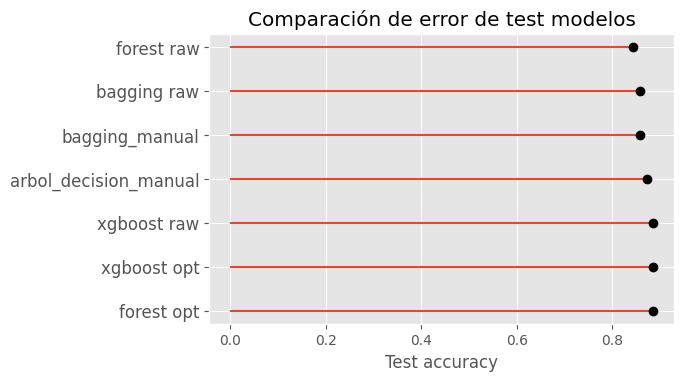

In [54]:
# Celda 8
accuracy = pd.DataFrame({
                        'model': ['bagging raw', 'forest raw', 'forest opt', 'xgboost raw', 'xgboost opt', 'arbol_decision_manual','bagging_manual'],
                        'accuracy': [accuracy_bagging, accuracy_forest, accuracy_forest_search, accuracy_xgboost, accuracy_xgboost_search,accu_TreeManual, accu_bagginManual]
                     })
accuracy = accuracy.sort_values('accuracy', ascending=False)
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.hlines(accuracy.model, xmin=0, xmax=accuracy.accuracy)
ax.plot(accuracy.accuracy, accuracy.model, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Comparación de error de test modelos'),
ax.set_xlabel('Test accuracy')
plt.show()

Como conclusión general del ejercicio es posible observar que la optimización genera no sólo una mejora sustancial en los resultados cuantitativos de predicción, sino que también mejoran los tiempos de procesamiento. No obstante, en este caso en particular la optimización de modelos xgboost tuvo como resultado cuantitativo un incremento poco sustancial de su accuracy, 
Por lo cual es posible decir que, el costo de procesamiento (al menos de los hiperparámetros del modelo tras casi 12 horas de procesamiento) no son significativos. Y en el caso del mismo random forest el incremento es de tan solo 3%. 


Situaciones como las anteriores nos motivan a observar otras realidades adicionales como la que exponemos a continuación.

En nuestra opinión, si la diferencia de desempeño no es significativo evitaría a todo costo usar  la librería `xgboost` esto se debe al estado de salud de tener una librería que no esté soportada en https://numfocus.org/sponsored-projects o otra fuente importante de financiamiento esto deriva a hechos como las métricas de actividad de desarrollo al repositorio q es casi nulo, y a su nulo soporte. Otro punto fundamental a tener en cuenta es que esta librería se basa en sklearn por ende puede romperse con actualizaciones futuras. Sin contar problemas que puede suceder con librerías de este índole como casos recientes en npm de `colors`, `faker` entre otras.

No obstante es importante resaltar que realmente la conclusión del ejercicio es que los árboles de decisión en cualquiera de sus formas son un método robusto tanto para clasificación como para predicción y que las pequeñas o grandes mejoras que puedan entregar la optimización de los modelos serán una decisión importante a analizar en cada ejercicio futuro.